# Compare Different Shapley-guided Data Selection Strateties



The accuracy of rank is 0.384765625
The accuracy of roulette is 0.458984375
The accuracy of softmax is 0.537109375
The accuracy of threshold is 0.611328125
The accuracy of dynamic is 0.6328125
{'rank': 0.384765625, 'roulette': 0.458984375, 'softmax': 0.537109375, 'threshold': 0.611328125, 'dynamic': 0.6328125}
Strategy: rank, Selection Size: 0.1, Accuracy: 0.66015625
Strategy: rank, Selection Size: 0.2, Accuracy: 0.673828125
Strategy: rank, Selection Size: 0.3, Accuracy: 0.703125
Strategy: rank, Selection Size: 0.4, Accuracy: 0.70703125
Strategy: rank, Selection Size: 0.5, Accuracy: 0.708984375
Strategy: roulette, Selection Size: 0.1, Accuracy: 0.71484375
Strategy: roulette, Selection Size: 0.2, Accuracy: 0.73046875
Strategy: roulette, Selection Size: 0.3, Accuracy: 0.73046875
Strategy: roulette, Selection Size: 0.4, Accuracy: 0.734375
Strategy: roulette, Selection Size: 0.5, Accuracy: 0.73828125
Strategy: softmax, Selection Size: 0.1, Accuracy: 0.736328125
Strategy: softmax, Selection

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Strategy: softmax, Selection Size: 0.5, Accuracy: 0.740234375
Strategy: threshold, Selection Size: 0.1, Accuracy: 0.73828125
Strategy: threshold, Selection Size: 0.2, Accuracy: 0.744140625
Strategy: threshold, Selection Size: 0.3, Accuracy: 0.744140625
Strategy: threshold, Selection Size: 0.4, Accuracy: 0.75
Strategy: threshold, Selection Size: 0.5, Accuracy: 0.763671875
Strategy: dynamic, Selection Size: 0.1, Accuracy: 0.759765625
Strategy: dynamic, Selection Size: 0.2, Accuracy: 0.755859375
Strategy: dynamic, Selection Size: 0.3, Accuracy: 0.759765625
Strategy: dynamic, Selection Size: 0.4, Accuracy: 0.76171875
Strategy: dynamic, Selection Size: 0.5, Accuracy: 0.763671875


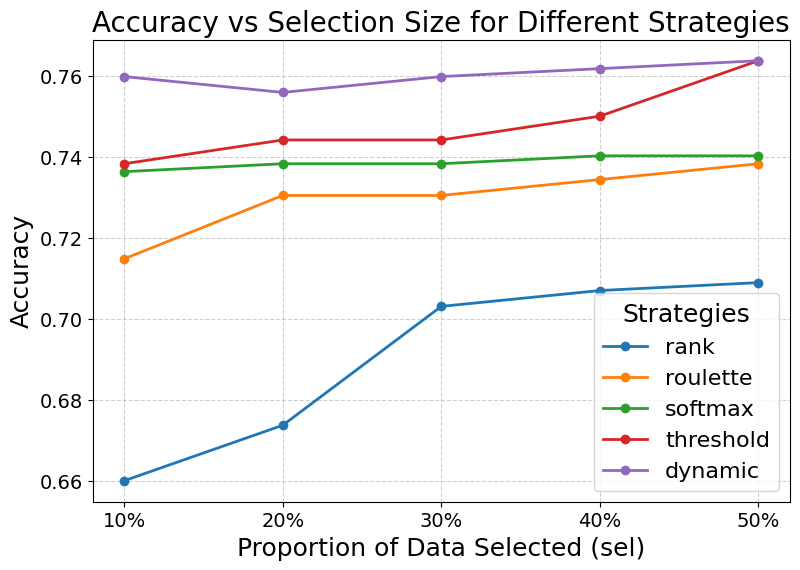

In [ ]:
## simple.py
## A simple example
import os
import sys

sys.path.append(os.path.abspath('./src/'))

import torch
from pickle import load, dump
from sklearn import preprocessing
from matplotlib import pyplot as plt

import valda
from valda.valuation import DataValuation
from valda.pyclassifier import PytorchClassifier
from valda.eval import data_removal, data_selection
from valda.metrics import weighted_acc_drop
from valda.params import Parameters
import numpy as np

np.random.seed(0)

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        outputs = self.softmax(self.linear(x))
        return outputs


def main():
    data = load(open('./data/diabetes.pkl', 'rb'))
    trnX, trnY = data['trnX'], data['trnY']
    devX, devY = data['devX'], data['devY']
    tstX, tstY = data['tstX'], data['tstY']
    # print('trnX.shape = {}'.format(trnX.shape))

    labels = list(set(trnY))
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    trnY = le.transform(trnY)
    devY = le.transform(devY)
    tstY = le.transform(tstY)

    model = LogisticRegression(input_dim=trnX.shape[1], output_dim=len(labels))
    clf = PytorchClassifier(model, epochs=20, trn_batch_size=16,
                                dev_batch_size=16)

    dv = DataValuation(trnX, trnY, devX, devY)

    params = Parameters()
    # params.update({'second_order_grad':True})
    # params.update({'for_high_value':False})

    if os.path.exists('./data/vals.pkl'):
        vals = load(open('./data/vals.pkl', 'rb'))
    else:
        vals = dv.estimate(clf=clf, method='tmc-shapley', params=params.get_values())
        dump(vals, open('./data/vals.pkl', 'wb'))
    # print(vals)

    # accs = data_removal(vals, trnX, trnY, tstX, tstY, clf)

    dict_acc_sel = dict()
    strategies = ['rank', 'roulette', 'softmax', 'threshold', 'dynamic']
    for strategy in strategies:
        acc_sel = data_selection(vals, 
                                 trnX, trnY, tstX, tstY, 
                                 clf,
                                 sel=0.2,
                                 strategy=strategy)
        print("The accuracy of {} is {}".format(strategy, acc_sel))
        dict_acc_sel[strategy] = acc_sel
    print(dict_acc_sel)

    import matplotlib.pyplot as plt

    # Placeholder for results
    strategies = ['rank', 'roulette', 'softmax', 'threshold', 'dynamic']
    selection_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]
    results = {strategy: [] for strategy in strategies}

    # Simulate data selection and store accuracies
    for strategy in strategies:
        for sel in selection_sizes:
            acc_sel = data_selection(vals, 
                                    trnX, trnY, tstX, tstY, 
                                    clf,
                                    sel=sel,
                                    strategy=strategy)
            results[strategy].append(acc_sel)
            print(f"Strategy: {strategy}, Selection Size: {sel:.1f}, Accuracy: {acc_sel}")

    # Plot the results for all strategies
    plt.figure(figsize=(9, 6))
    for strategy in strategies:
        plt.plot(selection_sizes, results[strategy], marker='o', linestyle='-', linewidth=2, label=strategy)

    # Add plot details
    plt.title('Accuracy vs Selection Size for Different Strategies', fontsize=20)
    plt.xlabel('Proportion of Data Selected (sel)', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.xticks(selection_sizes, [f"{int(sel * 100)}%" for sel in selection_sizes], fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Strategies", fontsize=16, title_fontsize=18)
    # plt.savefig('diabetes.eps', format='eps')

    # res = weighted_acc_drop(accs)
    # print("The weighted accuracy drop is {}".format(res))
    # plt.plot(res)
    plt.show()
    # print(accs)

# if __name__ == '__main__':
#     for _ in range(10):
#         main()
main()